# **Image Classification**
Image classification is the task of assigning a label or class to an image. There are many applications for image classification, such as detecting damage after a natural disaster, monitoring crop health, or helping screen medical images for signs of disease.

We shall use a pretrained model, MobileNet V2 from TensorFlow Hub and fine-tune it using flowers dataset.

### **1. Import Required Libraries**

In [ ]:
import pathlib
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

### **2. Load Data**

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
print('data_dir:', data_dir)

data_dir: /root/.keras/datasets/flower_photos


In [ ]:
img_height = 224
img_width = 224
batch_size = 32

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=44
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=44
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = np.array(train_dataset.class_names)
class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

### **3. Preprocess Data**

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1.0/255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### **4. Predict using Pretrained Model**

In [ ]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

model = tf.keras.Sequential([
    hub.KerasLayer(mobilenet_v2, input_shape=(img_height, img_width, 3))
])

In [ ]:
# ImageNet dataset labels
labels_url = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', origin=labels_url)

imagenet_labels = np.array(open(labels_path).read().splitlines())
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

In [ ]:
result = model.predict(validation_dataset)

predicted_class = imagenet_labels[tf.math.argmax(result, axis=-1)]

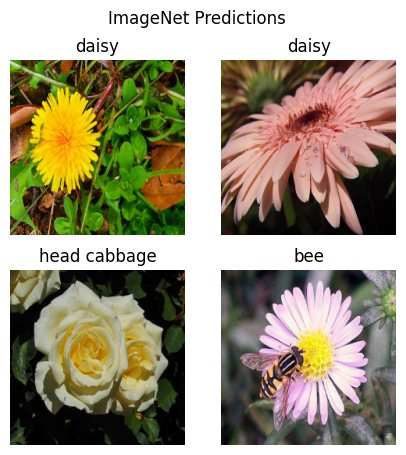

In [ ]:
plt.figure(figsize=(5, 5))

for images, labels in validation_dataset.take(1):
  for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.imshow(images[idx])
    plt.title(predicted_class[idx])
    plt.axis('off')
    plt.suptitle('ImageNet Predictions')

### **5. Predict using Pretrained Model after Fine-tuning**

In [ ]:
# MobileNetV2 model without top classification layer
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

base_model = hub.KerasLayer(mobilenet_v2, input_shape=(img_height, img_width, 3), trainable=False)

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# Fine-tuning the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

log_dir = "logs/fit/log"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=tensorboard_callback, verbose=1)

Epoch 1/10
92/92 [==============================] - 161s 2s/step - loss: 0.7407 - accuracy: 0.7258 - val_loss: 0.4448 - val_accuracy: 0.8542
Epoch 2/10
92/92 [==============================] - 156s 2s/step - loss: 0.3474 - accuracy: 0.8886 - val_loss: 0.3678 - val_accuracy: 0.8719
Epoch 3/10
92/92 [==============================] - 155s 2s/step - loss: 0.2688 - accuracy: 0.9189 - val_loss: 0.3376 - val_accuracy: 0.8774
Epoch 4/10
92/92 [==============================] - 166s 2s/step - loss: 0.2230 - accuracy: 0.9339 - val_loss: 0.3213 - val_accuracy: 0.8774
Epoch 5/10
92/92 [==============================] - 160s 2s/step - loss: 0.1908 - accuracy: 0.9496 - val_loss: 0.3115 - val_accuracy: 0.8828
Epoch 6/10
92/92 [==============================] - 148s 2s/step - loss: 0.1659 - accuracy: 0.9608 - val_loss: 0.3058 - val_accuracy: 0.8869
Epoch 7/10
92/92 [==============================] - 159s 2s/step - loss: 0.1459 - accuracy: 0.9666 - val_loss: 0.3026 - val_accuracy: 0.8869
Epoch 8/10
92

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=logs/fit

In [ ]:
# Predicting using the fine-tuned model
images, labels = next(iter(validation_dataset))

predictions = model.predict(images)
predicted_id = tf.math.argmax(predictions, axis=-1)
predicted_class = class_names[predicted_id]

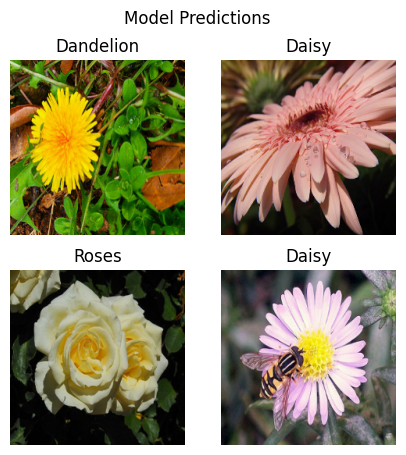

In [ ]:
plt.figure(figsize=(5, 5))

for images, labels in validation_dataset.take(1):
  for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.imshow(images[idx])
    plt.title(predicted_class[idx].title())
    plt.axis('off')
    plt.suptitle('Model Predictions')

In [ ]:
# Saving the fine-tuned model
export_path = "/tmp/saved_models/trained_model"
model.save(export_path)

# Reloading the saved model
reloaded_model = tf.keras.models.load_model(export_path)

# Predicting using the reloaded model
reloaded_result = reloaded_model.predict(images)
reloaded_predicted_id = tf.math.argmax(reloaded_result, axis=-1)
reloaded_predicted_class = class_names[reloaded_predicted_id]

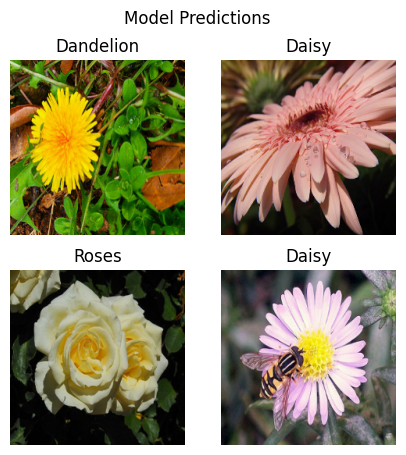

In [ ]:
plt.figure(figsize=(5, 5))

for images, labels in validation_dataset.take(1):
  for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.imshow(images[idx])
    plt.title(reloaded_predicted_class[idx].title())
    plt.axis('off')
    plt.suptitle('Model Predictions')